In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer

In [2]:
username = 'wreis79'
df = pd.read_csv(f'../../dados/base/chess_games_{username}.csv')
pd.options.display.max_columns = None

df = df[df['player'] == username]

print(f'{username} games: {df.shape}')
df.head()

wreis79 games: (5773, 35)


,url,pgn,time_control,end_time,rated,tcn,uuid,initial_setup,fen,time_class,rules,eco,accuracies,player,player_rating,opponent,opponent_rating,player_pieces,winner,win_method,start_time,move_list,material_count,move_evals,Brilliant,Best,Excellent,Good,Inaccuracy,Mistake,Blunder,Missed Mate,opening_eval,midgame_eval,winrate_with_opening
0,https://www.chess.com/game/live/5090302831,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,2020-07-02 16:38:06,True,mC!Tbs2Unv92ft0KgmXPeg6XjrWOcj3NoENEvETEdeEpfn...,edc7047a-bc80-11ea-9d92-eb3d40010001,NaN,8/4k3/1p2R3/p3K3/8/1P1B4/P1PPN3/8 b - -,blitz,chess,Alekhines Defense,"{'white': 35.11853272927611, 'black': 18.41488...",wreis79,994,cool19990,824,white,white,resigned,NaN,"['e2e4', 'g8f6', 'b1c3', 'g7g6', 'f2f3', 'f8g7...","[(39, 39), (39, 39), (39, 39), (39, 39), (39, ...","[{'type': 'cp', 'value': 30}, {'type': 'cp', '...",0,2,50,5,7,0,2,2,-1,3,unknown
1,https://www.chess.com/game/live/5090381747,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",300,2020-07-02 16:51:23,True,mC0Kgv!Tbs5QlB9RBJ8!JQXQfA6XegQIcM3VMF2MFwTCvK...,6b0468ce-bc83-11ea-9d92-eb3d40010001,NaN,r3r1kQ/1bp2pB1/3p4/p1p3p1/2B5/2P5/P1P2PPP/4qRK...,blitz,chess,Four Knights,"{'white': 80.15579937635584, 'black': 6.713954...",wreis79,873,pashulkaaa,1011,black,white,checkmated,NaN,"['e2e4', 'e7e5', 'g1f3', 'g8f6', 'b1c3', 'b8c6...","[(39, 39), (39, 39), (39, 39), (39, 39), (39, ...","[{'type': 'cp', 'value': 26}, {'type': 'cp', '...",0,2,23,3,1,0,5,2,2,-4,unknown
2,https://www.chess.com/game/live/5107789364,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",300,2020-07-06 07:47:29,True,mC0Kgv5Qbs!TlBKBsJTJCJQzvBzJdm90cl8!ecJzmAYIfm...,0cced7dc-bf5c-11ea-b33f-eb3d40010001,NaN,r5k1/3p1rp1/8/1p6/p3b3/8/1PP3PP/1K6 w - -,blitz,chess,Four Knights,"{'white': 13.195507624560634, 'black': 70.7961...",wreis79,789,abhishikth_789,911,white,black,resigned,NaN,"['e2e4', 'e7e5', 'g1f3', 'b8c6', 'b1c3', 'g8f6...","[(39, 39), (39, 39), (39, 39), (39, 39), (39, ...","[{'type': 'cp', 'value': 30}, {'type': 'cp', '...",0,1,39,5,4,1,3,0,0,-3,unknown
3,https://www.chess.com/game/live/5107807110,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",300,2020-07-06 07:48:25,True,mC0KdN2UNK,f8b4b440-bf5c-11ea-b33f-eb3d40010001,NaN,rnbqkbnr/pppp1p1p/6p1/4Q3/4P3/8/PPPP1PPP/RNB1K...,blitz,chess,Kings Pawn,NaN,wreis79,715,ka180,790,black,white,resigned,NaN,"['e2e4', 'e7e5', 'd1h5', 'g7g6', 'h5e5']","[(39, 39), (39, 39), (39, 39), (39, 39), (39, ...","[{'type': 'cp', 'value': 29}, {'type': 'cp', '...",0,0,3,0,0,0,1,0,2,2,unknown
4,https://www.chess.com/game/live/5107809885,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",300,2020-07-06 07:54:54,True,mC0KlBKBks5QfA!TcM3VMT7TblBsjsTRgv2Mpx92dyQKec...,1dca6b15-bf5d-11ea-b33f-eb3d40010001,NaN,8/pp2k3/7p/5p1P/8/8/r5p1/2K1r3 w - -,blitz,chess,Danish Gambit,"{'white': 51.60696469166051, 'black': 72.29809...",wreis79,751,NotHappyJan69,556,black,black,checkmated,NaN,"['e2e4', 'e7e5', 'd2d4', 'e5d4', 'c2c3', 'b8c6...","[(39, 39), (39, 39), (39, 39), (38, 39), (38, ...","[{'type': 'cp', 'value': 26}, {'type': 'cp', '...",0,12,37,2,7,2,2,1,-1,-3,unknown


In [3]:
def clean_base(data: pd.DataFrame):
    df = data.copy()
    # We only want to analyse normal chess games
    df = df[df['rules'] == 'chess']
    
    # Add the 'result' column
    def determine_result(row):
        if row['winner'] == 'draw':
            return 'draw'
        elif row['winner'] == row['player_pieces']:
            return 'win'
        else:
            return 'loss'
    
    df.loc[:, 'result'] = df.apply(determine_result, axis=1)

    # makes it so the value is in reference to the player advantage
    df.loc[df['player_pieces'] == 'black', 'opening_eval'] = (-1)*df.loc[df['player_pieces'] == 'black', 'opening_eval']
    df.loc[df['player_pieces'] == 'black', 'midgame_eval'] = (-1)*df.loc[df['player_pieces'] == 'black', 'midgame_eval']

    def treat_time_control(row):
        time_control = row['time_control']
        if '+' in row['time_control']:
            time, increment = time_control.split('+')
        elif '/' in row['time_control']:
            time = time_control.split('/')[1]
            if int(time) == 0:
                time = 9999999 # no time limit
            increment = 0
        else:
            time = row['time_control']
            increment = 0
        return pd.Series([int(time), int(increment)], index=['time_control', 'increment'])

    df.loc[:, ['time_control', 'increment']] = df.apply(treat_time_control, axis=1)

    df = df.drop([
        df.columns[0], 
        'url',
        'pgn', 
        'rated',
        'accuracies',
        'end_time',
        'rules', 
        'tcn', 
        'winner',
        'player',
        'opponent',
        'uuid', 
        'initial_setup', 
        'fen', 
        'start_time', 
        'move_list',
        'move_evals',
        'material_count',
        'win_method',
        'winrate_with_opening'
        ], axis=1)

    df.dropna(inplace=True)
    return df

df = clean_base(df)


In [4]:
print(f"Shape: {df.shape}\n")
print(f"Columns: {df.columns}\n")
for column in ['time_control', 'increment', 'time_class', 'player_pieces', 'opening_eval']:
    print(f'Unique values of {column}: {df[column].unique()}')

df.isna().sum()

Shape: (5773, 18)

Columns: Index(['time_control', 'time_class', 'eco', 'player_rating', 'opponent_rating',
       'player_pieces', 'Brilliant', 'Best', 'Excellent', 'Good', 'Inaccuracy',
       'Mistake', 'Blunder', 'Missed Mate', 'opening_eval', 'midgame_eval',
       'result', 'increment'],
      dtype='object')

Unique values of time_control: [600 300 180 900 3600 1800 60 120 9999999 30 259200]
Unique values of increment: [ 0  2 10  1  5 15]
Unique values of time_class: ['blitz' 'rapid' 'bullet' 'daily']
Unique values of player_pieces: ['white' 'black']
Unique values of opening_eval: [-1 -2  0  1 -4  3  2 -3  4]


time_control       0
time_class         0
eco                0
player_rating      0
opponent_rating    0
player_pieces      0
Brilliant          0
Best               0
Excellent          0
Good               0
Inaccuracy         0
Mistake            0
Blunder            0
Missed Mate        0
opening_eval       0
midgame_eval       0
result             0
increment          0
dtype: int64

In [5]:
df['time_control'].value_counts()
df['time_class'].value_counts()

time_class
bullet    5067
blitz      480
rapid      221
daily        5
Name: count, dtype: int64

In [6]:
df.head()

,time_control,time_class,eco,player_rating,opponent_rating,player_pieces,Brilliant,Best,Excellent,Good,Inaccuracy,Mistake,Blunder,Missed Mate,opening_eval,midgame_eval,result,increment
0,600,blitz,Alekhines Defense,994,824,white,0,2,50,5,7,0,2,2,-1,3,win,0
1,300,blitz,Four Knights,873,1011,black,0,2,23,3,1,0,5,2,-2,4,loss,0
2,300,blitz,Four Knights,789,911,white,0,1,39,5,4,1,3,0,0,-3,loss,0
3,300,blitz,Kings Pawn,715,790,black,0,0,3,0,0,0,1,0,-2,-2,loss,0
4,300,blitz,Danish Gambit,751,556,black,0,12,37,2,7,2,2,1,1,3,win,0


In [7]:
oe_time_class = OrdinalEncoder(categories=[['bullet', 'blitz', 'rapid', 'daily']])
ohe_eco = OneHotEncoder(sparse_output=False).set_output(transform='pandas')
le_player_pieces = LabelEncoder()
oe_result = OrdinalEncoder(categories=[['loss', 'draw', 'win']])
scaler = MinMaxScaler()

df['time_class'] = oe_time_class.fit_transform(df[['time_class']])
df['player_pieces'] = le_player_pieces.fit_transform(df['player_pieces'])
# df['result'] = oe_result.fit_transform(df[['result']])

eco_encoded = ohe_eco.fit_transform(df[['eco']])

df = pd.concat([df, eco_encoded], axis=1)
df.drop(columns=['eco'], axis = 1, inplace = True)

df[df.columns.drop('result')] = scaler.fit_transform(df[df.columns.drop('result')])

df.head()

,time_control,time_class,player_rating,opponent_rating,player_pieces,Brilliant,Best,Excellent,Good,Inaccuracy,Mistake,Blunder,Missed Mate,opening_eval,midgame_eval,result,increment,eco_Alapin Sicilian,eco_Alekhines Defense,eco_Anderssen Opening,eco_Barnes Opening,eco_Birds Opening,eco_Bishops Opening,eco_Caro Kann,eco_Catalan Opening,eco_Center Game,eco_Clemenz Opening,eco_Closed Sicilian,eco_Colle System,eco_Danish Gambit,eco_Dutch Defense,eco_English Defense,eco_English Opening,eco_Englund Gambit,eco_Four Knights,eco_French Defense,eco_Giuoco Piano,eco_Grob Opening,eco_Grunfeld Defense,eco_Indian Game,eco_Italian Game,eco_Kadas Opening,eco_Kings Fianchetto,eco_Kings Gambit,eco_Kings Indian,eco_Kings Pawn,eco_London System,eco_Mieses Opening,eco_Modern Defense,eco_Nimzo Indian,eco_Nimzowitsch Defense,eco_Nimzowitsch Larsen,eco_Old Benoni,eco_Petrovs Defense,eco_Philidor Defense,eco_Pirc Defense,eco_Polish Opening,eco_Ponziani Opening,eco_Queens Gambit,eco_Queens Pawn,eco_Reti Opening,eco_Ruy Lopez,eco_Saragossa Opening,eco_Scandinavian Defense,eco_Scotch Game,eco_Semi Slav,eco_Sicilian Defense,eco_Slav Defense,eco_Tarrasch Defense,eco_Three Knights,eco_Trompowsky Attack,eco_Van Geet,eco_Van t,eco_Vienna Game,eco_Ware Opening
0,0.000057,0.333333,0.607103,0.309666,1.0,0.0,0.025641,0.388889,0.277778,0.538462,0.000000,0.142857,0.2,0.375,0.875,win,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000027,0.333333,0.472808,0.389649,0.0,0.0,0.025641,0.174603,0.166667,0.076923,0.000000,0.357143,0.2,0.250,1.000,loss,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000027,0.333333,0.379578,0.346878,1.0,0.0,0.012821,0.301587,0.277778,0.307692,0.043478,0.214286,0.0,0.500,0.125,loss,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000027,0.333333,0.297447,0.295124,0.0,0.0,0.000000,0.015873,0.000000,0.000000,0.000000,0.071429,0.0,0.250,0.250,loss,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000027,0.333333,0.337403,0.195038,0.0,0.0,0.153846,0.285714,0.111111,0.538462,0.086957,0.142857,0.1,0.625,0.875,win,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
def remove_columns(data: pd.DataFrame, columns_to_remove: list[str]) -> pd.DataFrame:
    df = data.copy()
    for column in df.columns:
        if any(column_to_remove in column for column_to_remove in columns_to_remove):
            df.drop([column], axis=1, inplace=True)
    return df

In [9]:
def treat_outliers(data: pd.DataFrame) -> pd.DataFrame:
    df = data.copy()
    for col in ['rating', 'opponent_rating']:
        if col not in df.columns:
            continue
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
    return df

test = treat_outliers(df)
test.shape

(5543, 75)

In [10]:
# we will try combinations removing the following columns: 
# time_control, increment, win_method, winrate_with_opening
column_combinations = [
    [],
    ['time_control', 'increment'],
    ['player_rating', 'opponent_rating'],
    ['time_control', 'increment', 'player_rating', 'opponent_rating'],
]

In [11]:
params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 7, 10],
    'min_samples_leaf': [3, 10, 25],
}

model_params = {
    'Árvore de Classificação': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy', 'log_loss'],
            'splitter': ['best', 'random'],
            'max_depth': [None, 7, 10],
            'min_samples_leaf': [3, 10, 25],
        }
    }
}

In [12]:
columns = pd.MultiIndex.from_tuples([
    ('Pré-Processamento', 'Outliers', 'manter'),
    ('Pré-Processamento', 'Outliers', 'remover'),

    ('Pré-Processamento', 'Remover Coluna', 'time_control'),
    ('Pré-Processamento', 'Remover Coluna', 'increment'),
    ('Pré-Processamento', 'Remover Coluna', 'player_rating'),
    ('Pré-Processamento', 'Remover Coluna', 'opponent_rating'),

    ('Mineração de Dados', 'Árvore de Classificação', f'criterion={params["criterion"][0]}'),
    ('Mineração de Dados', 'Árvore de Classificação', f'criterion={params["criterion"][1]}'),
    ('Mineração de Dados', 'Árvore de Classificação', f'criterion={params["criterion"][2]}'),
    ('Mineração de Dados', 'Árvore de Classificação', f'splitter={params["splitter"][0]}'),
    ('Mineração de Dados', 'Árvore de Classificação', f'splitter={params["splitter"][1]}'),
    ('Mineração de Dados', 'Árvore de Classificação', f'max_depth={params["max_depth"][0]}'),
    ('Mineração de Dados', 'Árvore de Classificação', f'max_depth={params["max_depth"][1]}'),
    ('Mineração de Dados', 'Árvore de Classificação', f'max_depth={params["max_depth"][2]}'),
    ('Mineração de Dados', 'Árvore de Classificação', f'min_samples_leaf={params["min_samples_leaf"][0]}'),
    ('Mineração de Dados', 'Árvore de Classificação', f'min_samples_leaf={params["min_samples_leaf"][1]}'),
    ('Mineração de Dados', 'Árvore de Classificação', f'min_samples_leaf={params["min_samples_leaf"][2]}'),

    ('Pós-Processamento', 'Medidas', 'Acurácia'),
    ('Pós-Processamento', 'Medidas', 'Precisão'),
    ('Pós-Processamento', 'Medidas', 'Recall'),
    ('Pós-Processamento', 'Medidas', 'F-Measure')
])

experiment = pd.DataFrame(columns=columns)
experiment.head()

Empty DataFrame
Columns: [(Pré-Processamento, Outliers, manter), (Pré-Processamento, Outliers, remover), (Pré-Processamento, Remover Coluna, time_control), (Pré-Processamento, Remover Coluna, increment), (Pré-Processamento, Remover Coluna, player_rating), (Pré-Processamento, Remover Coluna, opponent_rating), (Mineração de Dados, Árvore de Classificação, criterion=gini), (Mineração de Dados, Árvore de Classificação, criterion=entropy), (Mineração de Dados, Árvore de Classificação, criterion=log_loss), (Mineração de Dados, Árvore de Classificação, splitter=best), (Mineração de Dados, Árvore de Classificação, splitter=random), (Mineração de Dados, Árvore de Classificação, max_depth=None), (Mineração de Dados, Árvore de Classificação, max_depth=7), (Mineração de Dados, Árvore de Classificação, max_depth=10), (Mineração de Dados, Árvore de Classificação, min_samples_leaf=3), (Mineração de Dados, Árvore de Classificação, min_samples_leaf=10), (Mineração de Dados, Árvore de Classificação, min_samples_leaf=25), (Pós-Processamento, Medidas, Acurácia), (Pós-Processamento, Medidas, Precisão), (Pós-Processamento, Medidas, Recall), (Pós-Processamento, Medidas, F-Measure)]
Index: []

In [13]:
scorers = {
    'Accuracy': make_scorer(accuracy_score),
    'Precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'Recall': make_scorer(recall_score, average='weighted'),
    'F1-Score': make_scorer(f1_score, average='weighted')
}

In [14]:
# TODO: figure out how to handle multiple class classification (the precision metric is doing a division by 0)
# df = df[df['result'] != 'draw']

# Split data
np.random.seed(42)
train, test = train_test_split(df, train_size=0.8, random_state=42)

In [15]:
best_scenario = {
    'F-Measure': 0
}

def set_best_scenario(model, remove_outliers, columns_to_remove, params, f_measure):
    best_scenario['model'] = model
    best_scenario['remove_outliers'] = remove_outliers
    best_scenario['columns_to_remove'] = columns_to_remove
    best_scenario['params'] = params
    best_scenario['F-Measure'] = f_measure


In [16]:
scores = []

for remove_outliers in [True, False]:
    for combination in column_combinations:
        train_treated = remove_columns(train, combination)
        if remove_outliers:
            train_treated = treat_outliers(train)

        X_train = train_treated.drop('result', axis=1)
        y_train = train_treated['result']
        
        for model_name, mp in model_params.items():
            clf = GridSearchCV(mp['model'], mp['params'], cv=5, scoring=scorers, return_train_score=False, refit='F1-Score')
            clf.fit(X_train, y_train)

            results = pd.DataFrame(clf.cv_results_)[['params', 'mean_test_Accuracy', 'mean_test_Precision', 'mean_test_Recall', 'mean_test_F1-Score']]

            for _, metrics in results.iterrows():
                if metrics['mean_test_F1-Score'] > best_scenario['F-Measure']:
                    set_best_scenario(clf.best_estimator_, remove_outliers, combination, metrics['params'], metrics['mean_test_F1-Score'])

                row = pd.Series(index=columns, dtype=str)
                row[:] = ' '

                if remove_outliers:
                    row[('Pré-Processamento', 'Outliers', 'remover')] = 'x'
                else:
                    row[('Pré-Processamento', 'Outliers', 'manter')] = 'x'
                
                for column in combination:
                    row[('Pré-Processamento', 'Remover Coluna', column)] = 'x'
                
                for param_name, param_value in metrics['params'].items():
                    row[('Mineração de Dados', f'{model_name}', f'{param_name}={param_value}')] = 'x'
                
                row[('Pós-Processamento', 'Medidas', 'Acurácia')] = metrics['mean_test_Accuracy']
                row[('Pós-Processamento', 'Medidas', 'Precisão')] = metrics['mean_test_Precision']
                row[('Pós-Processamento', 'Medidas', 'Recall')] = metrics['mean_test_Recall']
                row[('Pós-Processamento', 'Medidas', 'F-Measure')] = metrics['mean_test_F1-Score']

                experiment.loc[len(experiment)] = row 

print(experiment.shape)
experiment.head()

(432, 21)


Pré-Processamento                                                 \
           Outliers         Remover Coluna                           
             manter remover   time_control increment player_rating   
0                         x                                          
1                         x                                          
2                         x                                          
3                         x                                          
4                         x                                          

                       Mineração de Dados                    \
                  Árvore de Classificação                     
  opponent_rating          criterion=gini criterion=entropy   
0                                       x                     
1                                       x                     
2                                       x                     
3                                       x                     
4                                       x                     

                                                                               \
                                                                                
  criterion=log_loss splitter=best splitter=random max_depth=None max_depth=7   
0                                x                              x               
1                                                x              x               
2                                x                              x               
3                                                x              x               
4                                x                              x               

                                                                           \
                                                                            
  max_depth=10 min_samples_leaf=3 min_samples_leaf=10 min_samples_leaf=25   
0                               x                                           
1                               x                                           
2                                                   x                       
3                                                   x                       
4                                                                       x   

  Pós-Processamento                                
            Medidas                                
           Acurácia  Precisão    Recall F-Measure  
0          0.723303  0.720629  0.723303  0.721725  
1          0.716313  0.716587  0.716313  0.715974  
2          0.753942  0.747471  0.753942  0.749477  
3           0.76138  0.749859   0.76138  0.754202  
4           0.76476  0.753713   0.76476  0.758082

In [17]:
experiment.sort_values(('Pós-Processamento', 'Medidas', 'F-Measure'), ascending=False, inplace=True)
print(f"Experiment Sorted by F-Measure ({experiment.shape})")
experiment.head(30)

Experiment Sorted by F-Measure ((432, 21))


Pré-Processamento                                                 \
             Outliers         Remover Coluna                           
               manter remover   time_control increment player_rating   
35                          x                                          
333                 x                                              x   
424                 x                      x         x             x   
370                 x                                              x   
352                 x                                              x   
406                 x                      x         x             x   
33                          x                                          
241                 x                                                  
260                 x                                                  
242                 x                                                  
353                 x                                              x   
368                 x                                              x   
350                 x                                              x   
296                 x                      x         x                 
314                 x                      x         x                 
403                 x                      x         x             x   
44                          x                                          
417                 x                      x         x             x   
429                 x                      x         x             x   
188                         x              x         x             x   
177                         x              x         x             x   
80                          x              x         x                 
152                         x                                      x   
404                 x                      x         x             x   
366                 x                                              x   
134                         x                                      x   
114                         x                                      x   
26                          x                                          
243                 x                                                  
323                 x                      x         x                 

                         Mineração de Dados                    \
                    Árvore de Classificação                     
    opponent_rating          criterion=gini criterion=entropy   
35                                                          x   
333               x                       x                     
424               x                                             
370               x                                             
352               x                                         x   
406               x                                         x   
33                                                          x   
241                                                         x   
260                                                             
242                                                         x   
353               x                                         x   
368               x                                             
350               x                                         x   
296                                                         x   
314                                                             
403               x                                         x   
44                                                              
417               x                                             
429               x                                             
188               x                                         x   
177               x                       x                     
80                                                          x   
15

In [18]:
# Save to Excel
experiment.to_excel('decision_tree_grid_search_results.xlsx')
print("Results saved to 'decision_tree_grid_search_results.xlsx'")

Results saved to 'decision_tree_grid_search_results.xlsx'


In [19]:
print(best_scenario['params'])
print(best_scenario['model'].get_params())


{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 25, 'splitter': 'random'}
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 25, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'random'}


In [20]:
best_model = best_scenario['model']

train_treated = remove_columns(train, best_scenario['columns_to_remove'])

if best_scenario['remove_outliers']:
    train_treated = treat_outliers(train_treated)

X_train = train_treated.drop('result', axis=1)
y_train = train_treated['result']

best_model.fit(X_train, y_train)

test_treated = remove_columns(test, best_scenario['columns_to_remove'])

if best_scenario['remove_outliers']:
    test_treated = treat_outliers(test_treated)

X_test = train_treated.drop('result', axis=1)
y_test = train_treated['result']

pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred, average='weighted', zero_division=0)
recall = recall_score(y_test, pred, average='weighted')
f1 = f1_score(y_test, pred, average='weighted')

print(f"Accuracy: {accuracy:.4%}")
print(f"Precision: {precision:.4%}")
print(f"Recall: {recall:.4%}")
print(f"F1 Score: {f1:.4%}\n")

Accuracy: 78.7517%
Precision: 77.9728%
Recall: 78.7517%
F1 Score: 78.0834%



In [21]:
importance_values = best_model.tree_.compute_feature_importances(normalize=True)

feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance_values
})

eco_importances = feature_importances[feature_importances['Feature'].str.startswith('eco')]
eco_importance_sum = eco_importances['Importance'].sum()
opening = pd.DataFrame({'Feature': ['opening'], 'Importance': [eco_importance_sum]})

feature_importances = feature_importances[~feature_importances['Feature'].str.startswith('eco')]

feature_importances = pd.concat([feature_importances, opening], ignore_index=True)

feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

feature_importances

,Feature,Importance
14,midgame_eval,0.603165
11,Blunder,0.103585
7,Excellent,0.082533
6,Best,0.072024
4,player_pieces,0.051024
3,opponent_rating,0.019246
13,opening_eval,0.012989
9,Inaccuracy,0.012817
16,opening,0.012363
8,Good,0.009581


Plot do melhor modelo


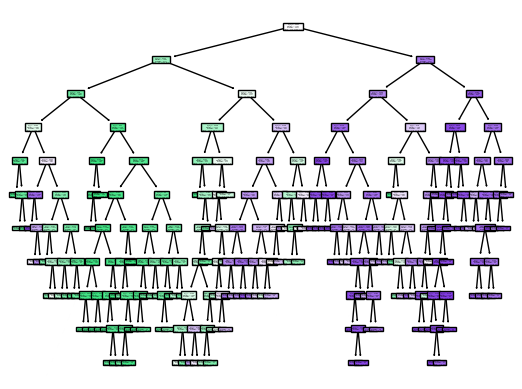

In [22]:
plot_tree(best_model,  filled=True)
plt.savefig('decision_tree.svg', format='svg')
print("Plot do melhor modelo")